In [239]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from category_encoders import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

In [240]:

# 데이터 불러오기
df = pd.read_csv('C:/Users/hm981/OneDrive/바탕 화면/AI부트캠프/project/teamproject2/feature_target.csv')  # 데이터셋 파일 경로 지정

# 데이터 탐색 및 전처리
df.drop(columns = ['customer_id', 'first_join_date'], inplace =True)

df.loc[:,'low'] = df.loc[:,'low'].astype('float32')
df.loc[:,'high'] = df.loc[:,'high'].astype('float32')
df.loc[:,'book_cnt'] = df.loc[:,'book_cnt'].astype('Int32')
df.loc[:,'time/event'] = df.loc[:,'time/event'].astype('float32')
df.loc[:,'add_book_mean'] = df.loc[:,'add_book_mean'].astype('float32')
df['revisit'] = pd.to_timedelta(df['revisit']).dt.total_seconds()
df.loc[:,'session_cnt'] = df.loc[:,'session_cnt'].astype('Int32')
df.loc[:,'add_last_event_ratio'] = df.loc[:,'add_last_event_ratio'].astype('float32')
df.loc[:,'promo_use_ratio'] = df.loc[:,'promo_use_ratio'].astype('float32')
df.loc[:,'average_revenue'] = df.loc[:,'average_revenue'].astype('float64')


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50699 entries, 0 to 50698
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                50699 non-null  object 
 1   home_location         50699 non-null  object 
 2   age_segment           50699 non-null  object 
 3   RFM_Segment           50699 non-null  float64
 4   low                   50699 non-null  float64
 5   high                  50699 non-null  float64
 6   book_cnt              50699 non-null  int64  
 7   time/event            50699 non-null  float64
 8   add_book_mean         50699 non-null  float64
 9   revisit               50699 non-null  float64
 10  session_cnt           50699 non-null  int64  
 11  add_last_event_ratio  50699 non-null  float64
 12  promo_use_ratio       50699 non-null  float64
 13  average_revenue       50699 non-null  float64
 14  bounce                50699 non-null  int64  
dtypes: float64(9), int6

In [242]:
df_num = df.dtypes[(df.dtypes != "object") & (df.dtypes != "category")].index
df[df_num]


,RFM_Segment,low,high,book_cnt,time/event,add_book_mean,revisit,session_cnt,add_last_event_ratio,promo_use_ratio,average_revenue,bounce
0,322.0,0.135593,0.067797,89,104.576805,1.440230e+05,6.157089e+04,989,0.059656,0.202247,537850.168539,1
1,111.0,1.000000,0.000000,1,108.299011,2.456911e+02,0.000000e+00,1,0.000000,0.000000,115702.000000,1
2,211.0,0.000000,0.000000,2,260.637573,2.416852e+05,8.842406e+05,11,0.363636,0.500000,190362.000000,1
3,111.0,0.500000,0.250000,3,311.722778,4.970448e+05,3.793925e+06,17,0.235294,1.000000,770944.333333,1
4,111.0,0.333333,0.000000,3,261.235138,2.104414e+06,4.050262e+06,15,0.333333,0.666667,163779.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
50694,111.0,0.142857,0.142857,6,287.877563,3.547122e+06,3.550305e+06,38,0.210526,0.500000,568302.333333,1
50695,322.0,0.133333,0.200000,37,141.346207,3.203798e+05,9.602015e+04,584,0.034247,0.324324,429829.432432,1
50696,322.0,0.075472,0.075472,44,223.700867,5.135048e+05,3.813352e+05,381,0.225722,0.295455,702686.386364,1
50697,322.0,0.089172,0.133758,96,124.382912,2.481931e+05,9.673476e+04,1273,0.061273,0.375000,590131.125000,1


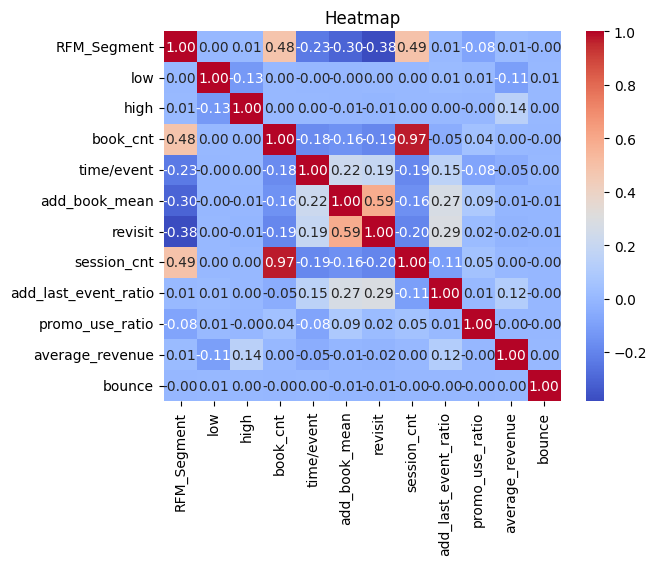

In [243]:
sns.heatmap(df[df_num].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Heatmap")
plt.show()


# 클래스 불균형

In [244]:
# baseline 정확도 0.82548
df['bounce'].value_counts(normalize =True)

bounce
1    0.82548
0    0.17452
Name: proportion, dtype: float64

In [245]:
from imblearn.over_sampling import SMOTE


# 특성과 목표 변수 분리
X = df.drop(columns=['bounce'], axis=1)
y = df['bounce']


numeric_feats = X.dtypes[(X.dtypes != "object") & (X.dtypes != "category")].index


In [246]:
# One-Hot encoding
ohe = OneHotEncoder()

X_ohe = ohe.fit_transform(X)

# SMOTE 적용
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_ohe, y)

# base모델

In [247]:

# 데이터 분할: 훈련 세트와 평가 세트
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 특성 스케일링: 표준화

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])


# 로지스틱 회귀 모델 생성
logreg = LogisticRegression(class_weight = {1: len(df[df['bounce'] == 0]) / len(df[df['bounce'] == 1])})

In [248]:
logreg.fit(X_train, y_train)

base_train_pred = logreg.predict(X_train)
base_test_pred = logreg.predict(X_test)

c:\Users\hm981\anaconda3\envs\tp2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [249]:
print(classification_report(y_train, base_train_pred))
print(classification_report(y_test, base_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.95      0.70     33480
           1       0.84      0.25      0.39     33481

    accuracy                           0.60     66961
   macro avg       0.70      0.60      0.55     66961
weighted avg       0.70      0.60      0.55     66961

              precision    recall  f1-score   support

           0       0.56      0.95      0.70      8371
           1       0.82      0.24      0.37      8370

    accuracy                           0.59     16741
   macro avg       0.69      0.59      0.54     16741
weighted avg       0.69      0.59      0.54     16741



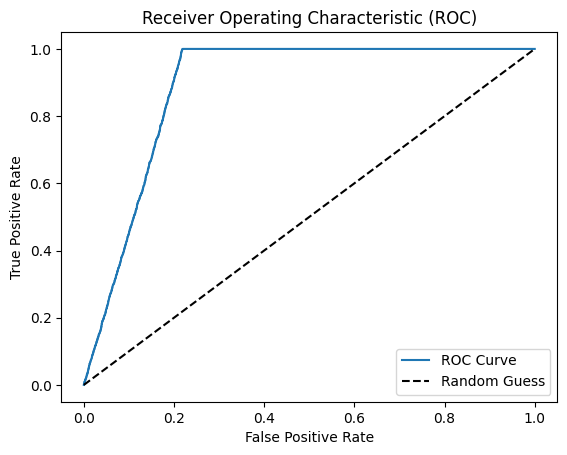

ROC AUC: 0.8894734010159385


In [250]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_log_proba(X_test)[:,1])

# ROC 곡선 그리기
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


roc_auc = roc_auc_score(y_test, logreg.predict_log_proba(X_test)[:,1])
print('ROC AUC:', roc_auc)

# grid search

In [271]:

# 특성과 목표 변수 분리
X = df.drop(columns=['bounce'], axis=1)
y = df['bounce']

ohe = OneHotEncoder()

X_ohe = ohe.fit_transform(X)

# SMOTE 적용
smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X_ohe, y)


# 데이터 분할: 훈련 세트와 평가 세트
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 특성 스케일링: 표준화
numeric_feats = X_train.dtypes[(X_train.dtypes != "object") & (X_train.dtypes != "category")].index

scaler = StandardScaler()
X_train[numeric_feats] = scaler.fit_transform(X_train[numeric_feats])
X_test[numeric_feats] = scaler.transform(X_test[numeric_feats])

# 로지스틱 회귀 모델 생성
logreg2 = LogisticRegression(class_weight = {1: 0.1})

In [272]:
def threshold_range(start, end, step):
    thresholds = np.arange(start, end, step)
    return thresholds.tolist()

# GridSearchCV에 사용할 매개변수 그리드 정의
thresholds = threshold_range(0.45, 0.55, 0.005)

In [273]:
param = {'multi_class' : ['ovr'],
        'C' : [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
        'max_iter' : range(100, 2000, 50)
        }

grid_search = GridSearchCV(logreg2, param, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight={1: 0.1}),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09, 0.1],
                         'max_iter': range(100, 2000, 50),
                         'multi_class': ['ovr']})

In [274]:

# 임계값 설정
threshold = 0.5

#훈련 스코어
train_proba = grid_search.predict_proba(X_train)[:, 1]
train_pred = (train_proba > threshold).astype(int)
train_accuracy = accuracy_score(y_train, train_pred)
print('train=', train_accuracy)


#테스트 스코어
y_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred = (y_proba > threshold).astype(int)
classification_rep = classification_report(y_test, y_pred, zero_division=1)
print(classification_rep)
accuracy_score(y_test, y_pred)

train= 0.5000224010991473
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      8371
           1       1.00      0.00      0.00      8370

    accuracy                           0.50     16741
   macro avg       0.75      0.50      0.33     16741
weighted avg       0.75      0.50      0.33     16741



0.5000298667940983

In [275]:
print("ROC_AUC_score", roc_auc_score(y_test, y_pred))

ROC_AUC_score 0.5


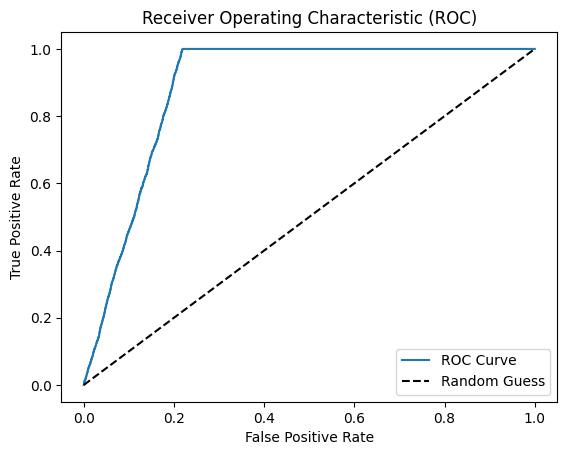

ROC AUC: 0.8906086853015767


In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# ROC 곡선 그리기
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


roc_auc = roc_auc_score(y_test, y_proba)
print('ROC AUC:', roc_auc)

In [277]:
best_model = grid_search.best_estimator_
feature_importance = best_model.coef_[0]


# 결과 출력
feature_set = pd.DataFrame()
ls1 = []
ls2 = []
for feature, importance in zip(X_train_ohe.columns, feature_importance):
    ls1.append(feature)
    ls2.append(importance)

In [278]:
best_model.get_params()

{'C': 0.04,
 'class_weight': {1: 0.1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [279]:
feature_set['feature'] = ls1
feature_set['importance'] = ls2

In [280]:
feature_set['abs'] = [abs(x) for x in ls2]

In [281]:
feature_set.sort_values('abs', ascending =False)

,feature,importance,abs
7,home_location_6,1.113645,1.113645
36,age_segment_2,1.078988,1.078988
38,age_segment_4,1.021765,1.021765
1,gender_2,0.949187,0.949187
5,home_location_4,0.887452,0.887452
37,age_segment_3,0.885248,0.885248
9,home_location_8,0.874324,0.874324
0,gender_1,0.849998,0.849998
35,age_segment_1,0.849937,0.849937
8,home_location_7,0.818463,0.818463
